In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
plt.style.use('seaborn-darkgrid')
%matplotlib inline

### コード2.1 コイン投げ問題を解く

In [49]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    grid = np.linspace(0, 1, grid_points)
    #prior = np.repeat(5, grid_points)
    #prior = (grid <= 0.5).astype(int) # 演習2.1の事前分布
    prior = np.random.uniform(0, 1, grid_points)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

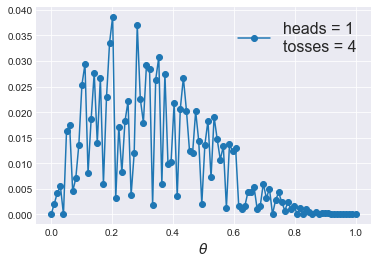

In [51]:
points = 100
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-', label='heads = {}\ntosses = {}'.format(h, n))
plt.xlabel(r'$\theta$', fontsize=14)
plt.legend(loc=0, fontsize=16)

### コード2.2 モンテカルロシュミレーションで円周率を計算する

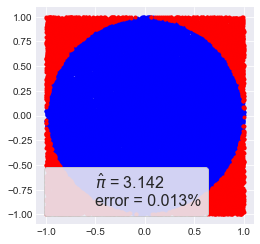

In [15]:
N = 30000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x ** 2 + y ** 2)  <= 1
pi = inside.sum()*4 / N
error = abs((pi - np.pi) / pi) * 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat\pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16)

### コード2.3 シンプルなメトロポリス法を実行する（１）

In [16]:
def metropolis(func, steps=10000):
    """A veru simple Metropolis implementation"""
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples

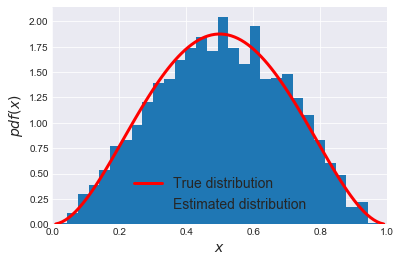

In [52]:
func = stats.beta(3, 3)
samples = metropolis(func)
x = np.linspace(0.01, 0.99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=30, normed=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)

In [18]:
import pymc3 as pm

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### コード2.5 事後分布をサンプリングし、トレースプロットする

In [19]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
print(data)

[1 0 0 0]


[1] モデルの記述<br>
$\theta ~ Beta(\alpha, \beta)$ <br>
$y ~ Bin(n = 1, p = \theta)$

logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 1549.14it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 4686.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


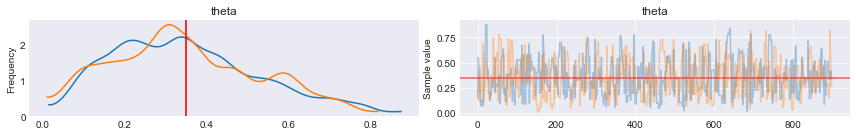

In [54]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    start = pm.find_MAP() # 最大事後確率の計算
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)
    #trace = pm.sample(1000, step=step)
    
    burnin = 100
    chain = trace[burnin:]
    pm.traceplot(chain, lines={'theta':theta_real})

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 4487.64draws/s]
The number of effective samples is smaller than 25% for some parameters.


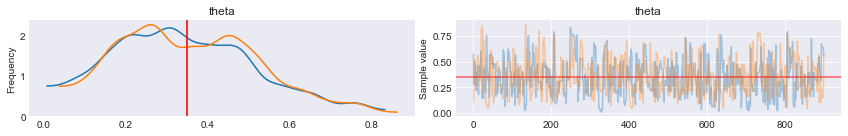

In [57]:
# 演習　５
with pm.Model() as our_first_model:
    #theta = pm.Beta('theta', alpha=1, beta=1)
    theta = pm.Uniform('theta', lower=0, upper=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    #start = pm.find_MAP() # 最大事後確率の計算
    step = pm.Metropolis()
    #trace = pm.sample(1000, step=step, start=start)
    trace = pm.sample(1000, step=step)
    
    burnin = 100
    chain = trace[burnin:]
    pm.traceplot(chain, lines={'theta':theta_real})

### コード2.9 事後分布を並列サンプリングし、トレースプロットする

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4091.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e9d81d0>,
      dtype=object)

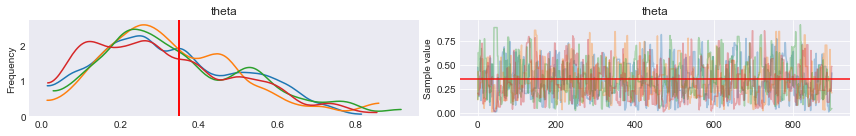

In [26]:
with our_first_model:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, njobs=4)
    
burnin = 100
multi_chain = multi_trace[burnin:]
pm.traceplot(multi_chain, lines={'theta':theta_real})

### コード2.10 事後分布を並列サンプリングし、平均、50%/95%HPD、および$\hat{R}$を出力する

In [27]:
# Rhatの出力
pm.gelman_rubin(multi_chain)

{'theta': 1.0030735212154092}

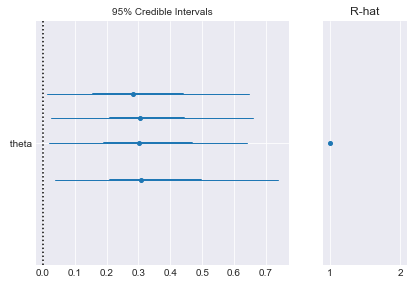

In [28]:
# 各パラメータ分布の平均や50%HPDおよび95%HPDを表示
pm.forestplot(multi_chain, varnames={'theta'})

In [29]:
# 要約統計量の出力
pm.summary(multi_chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.332271,0.18182,0.006531,0.018088,0.667972,764.679923,1.003074


### コード2.13 自己相関をグラフ表示する

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x103b67f60>,
      dtype=object)

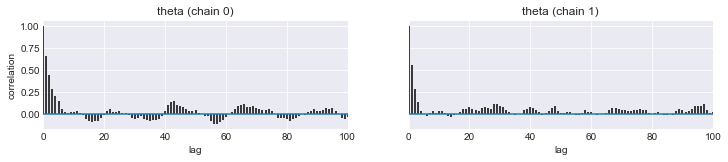

In [30]:
pm.autocorrplot(chain)

In [31]:
pm.effective_n(multi_chain)['theta']

764.6799225434833

## 2.3 事後分布の要約
### コード 2.14 事後分布と95%HPDを出力する

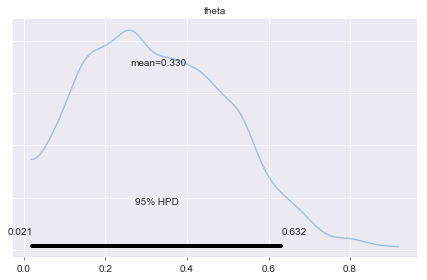

In [32]:
pm.plot_posterior(chain, kde_plot=True)

### コード2.15 事後分布とROPEを出力する

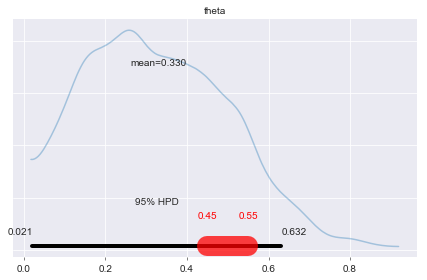

In [33]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45, 0.55])

### コード2.16 事後分布と参照点を出力する

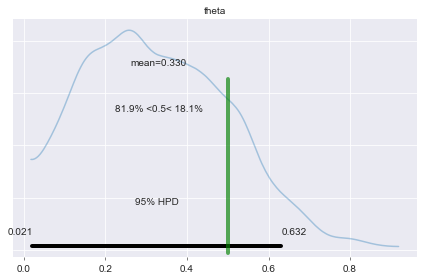

In [34]:
pm.plot_posterior(chain, kde_plot=True, ref_val=0.5)